In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy.optimize as spo

In [138]:
### Markowitz portfolio optimization
class Markowitz:
    """
    Returns the optimal portfolio weights and the corresponding Sharpe ratio.
    Reference: https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/resources/mit18_s096f13_lecnote14/
    Returns: Must have at least 2 assets each with at least 2 returns listed.
    Return period: >= 2, 12 for monthly, 52 for weekly, 252 for yearly.
    """
    def __init__(self, returns: list, return_period: int):
        self.UNIFORM_WEIGHTS = np.ones(len(returns)) / len(returns)
        self.RETURNS = np.asarray(returns).copy()
        self.FREQUENCY = return_period
        self.COV = np.cov(self.RETURNS)
    
    def _neg_sharpe_ratio(self, weights: list, risk_free_rate: float = 0.0):
        """
        Returns the Sharpe ratio of the portfolio.
        """
        expected_return = np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY
        standard_deviation = np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY)
        return (expected_return - risk_free_rate) / standard_deviation
    
    def _variance(self, weights: list):
        """
        Returns the variance of the portfolio.
        """
        return np.dot(weights.T, np.dot(self.COV, weights))

    # Return Maximization
    def max_sharpe(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        args = (risk_free_rate)
        # minimize the negative Sharpe ratio
        result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        # weights, Sharpe ratio
        return result.x, -result.fun, result.success
        
    # Risk Minimization
    def min_variance(self, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding variance.
        Use the variance as the objective function to be minimized.
        """
        # minimize the variance
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        # , 'type': 'eq', 'fun': lambda x: np.dot(x, self.RETURNS) - target_return
        constraints={'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        print("result.x", result.x)
        # weights, variance
        return result.x, result.fun, result.success

    # Optimize a portfolio given a target return or a target variance
    def optimize(self, target_return: float = None, target_variance: float = None, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Returns the optimal portfolio weights and the corresponding Sharpe ratio.
        Use the negative Sharpe ratio as the objective function to be minimized.
        """
        # minimize the negative Sharpe ratio
        init_weights = self.UNIFORM_WEIGHTS
        method='SLSQP'
        bounds=[weight_constraint] * len(self.RETURNS)
        if target_return is not None:
            constraints={'type': 'eq', 'fun': lambda x: np.dot(x, self.RETURNS) - target_return, 'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            args = (risk_free_rate)
            result = spo.minimize(self._neg_sharpe_ratio, init_weights, method=method, bounds=bounds, constraints=constraints, args=args)
        elif target_variance is not None:
            constraints={'type': 'eq', 'fun': lambda x: np.dot(x.T, np.dot(self.COV, x)) - target_variance, 'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            result = spo.minimize(self._variance, init_weights, method=method, bounds=bounds, constraints=constraints)
        else:
            raise ValueError("Must provide either a target return or a target variance, but not both.")
        
        # weights, Sharpe ratio
        return result.x, -result.fun, result.success
    
    # Plot the efficient frontier
    def efficient_frontier(self, risk_free_rate: float = 0.0, weight_constraint: tuple = (0,1)):
        """
        Plots the efficient frontier.
        Iterates through optimal portfolios from min_variance to max_sharpe.
        """
        # get the minimum variance portfolio
        min_var_weights, min_var, _ = self.min_variance(weight_constraint)
        # get the maximum Sharpe ratio portfolio
        max_sharpe_weights, max_sharpe, _ = self.max_sharpe(risk_free_rate, weight_constraint)
        # get the returns and standard deviations of the portfolios
        returns = []
        stds = []
        for i in range(100):
            # get the weights
            weights = min_var_weights * (1 - i/100) + max_sharpe_weights * (i/100)
            # get the returns and standard deviations
            returns.append(np.sum(np.dot(weights, self.RETURNS))*self.FREQUENCY)
            stds.append(np.sqrt(np.dot(weights, np.dot(self.COV, weights)))*np.sqrt(self.FREQUENCY))
        # plot the efficient frontier
        plt.figure(figsize=(10,6))
        plt.scatter(stds, returns, c=(np.array(returns)-risk_free_rate)/np.array(stds), marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label='Sharpe ratio')
        plt.title('Efficient Frontier')
        # plot the minimum variance portfolio
        plt.scatter(np.sqrt(min_var)*np.sqrt(self.FREQUENCY), np.sum(np.dot(min_var_weights, self.RETURNS))*self.FREQUENCY, c='red', marker='*', s=500)
        # plot the maximum Sharpe ratio portfolio
        plt.scatter(np.sqrt(max_sharpe)*np.sqrt(self.FREQUENCY), np.sum(np.dot(max_sharpe_weights, self.RETURNS))*self.FREQUENCY, c='blue', marker='*', s=500)
        plt.show()

        


Status:  True
Weights:  [1.00000000e+00 2.73409073e-12 1.68314251e-11 0.00000000e+00
 3.69343445e-12]
Sharpe Ratio:  -6.000000000139668 

result.x [0.0297619  0.20436508 0.33531746 0.20436508 0.22619048]
Status:  True
Weights:  [0.0297619  0.20436508 0.33531746 0.20436508 0.22619048]
Variance:  7.688961175772845e-20 

Status:  True
Weights:  [0.0297619  0.20436508 0.33531746 0.20436508 0.22619048]
Stat:  -7.688961175772845e-20
result.x [0.0297619  0.20436508 0.33531746 0.20436508 0.22619048]


/tmp/ipykernel_990/513975729.py:115: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(np.sqrt(max_sharpe)*np.sqrt(self.FREQUENCY), np.sum(np.dot(max_sharpe_weights, self.RETURNS))*self.FREQUENCY, c='blue', marker='*', s=500)


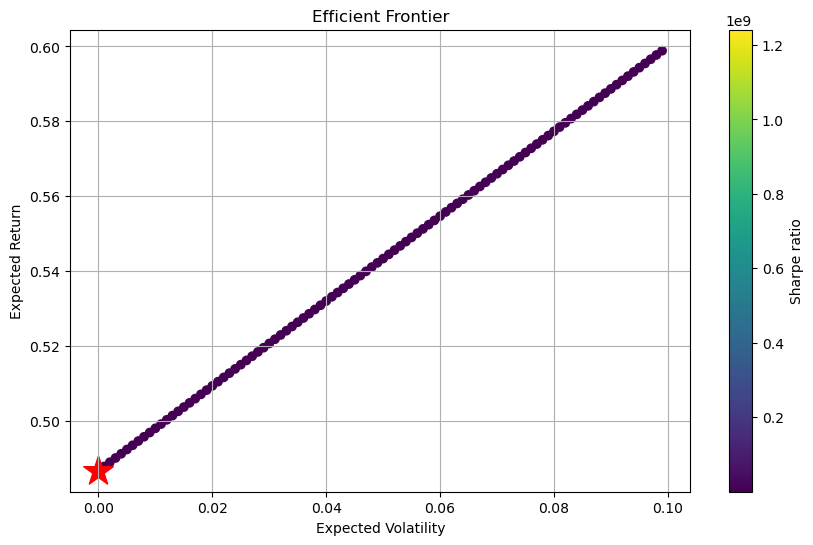

In [139]:
# test max sharpe
returns =[[0.1, 0.2], [0.15 ,0.17], [0.12,0.08], [0.09,0.11], [0.13,0.14]]
markowitz= Markowitz(returns, 2)
weights1, sharpe_ratio, status1 = markowitz.max_sharpe()
print("Status: ", status1)
print('Weights: ', weights1)
print('Sharpe Ratio: ', sharpe_ratio, '\n')

# test min variance
weights2, variance, status2 = markowitz.min_variance()
print("Status: ", status2)
print('Weights: ', weights2)
print('Variance: ', variance, '\n')

# test optimize
weights3, new_sharpe, status3 = markowitz.optimize(target_variance=variance)
print("Status: ", status3)
print('Weights: ', weights3)
print('Stat: ', new_sharpe)

# test efficient frontier
markowitz.efficient_frontier()

In [126]:
x =[[0, 0.2], [0 ,0.17], [0,0.08], [0,0.11], [0,0.14]]
w = [1/len(x)]*len(x)
cov = np.cov(x)
print("cov", cov)
print("w", w)

cov [[0.02    0.017   0.008   0.011   0.014  ]
 [0.017   0.01445 0.0068  0.00935 0.0119 ]
 [0.008   0.0068  0.0032  0.0044  0.0056 ]
 [0.011   0.00935 0.0044  0.00605 0.0077 ]
 [0.014   0.0119  0.0056  0.0077  0.0098 ]]
w [0.2, 0.2, 0.2, 0.2, 0.2]
